In [1]:
import pandas as pd 
import numpy as np 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor,Trainer, TrainingArguments, WavLMForSequenceClassification, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = []
labels = []
for dirname, _, filenames in os.walk(r'Data/TESS Toronto emotional speech set data'):
    for filename in filenames:
        path.append(os.path.join(dirname,filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(path) == 2800:
        break
print('Dataset is Loaded')
        

Dataset is Loaded


In [3]:
len(path)

2800

In [4]:
path[:5]

['Data/TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav',
 'Data/TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav',
 'Data/TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav',
 'Data/TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav',
 'Data/TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']

In [5]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

In [6]:
df = pd.DataFrame()
df['audio_paths'] = path
df['labels'] = labels
df.head()

audio_paths labels
0  Data/TESS Toronto emotional speech set data\OA...  angry
1  Data/TESS Toronto emotional speech set data\OA...  angry
2  Data/TESS Toronto emotional speech set data\OA...  angry
3  Data/TESS Toronto emotional speech set data\OA...  angry
4  Data/TESS Toronto emotional speech set data\OA...  angry

In [7]:
df['labels'].value_counts()

labels
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

<Axes: xlabel='labels', ylabel='count'>

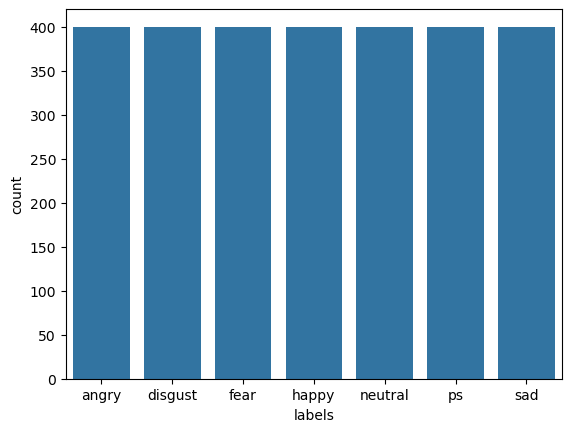

In [8]:
sns.countplot(data=df, x = 'labels')

In [9]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size = 20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion,size=20)
    librosa.display.specshow(xdb, sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()

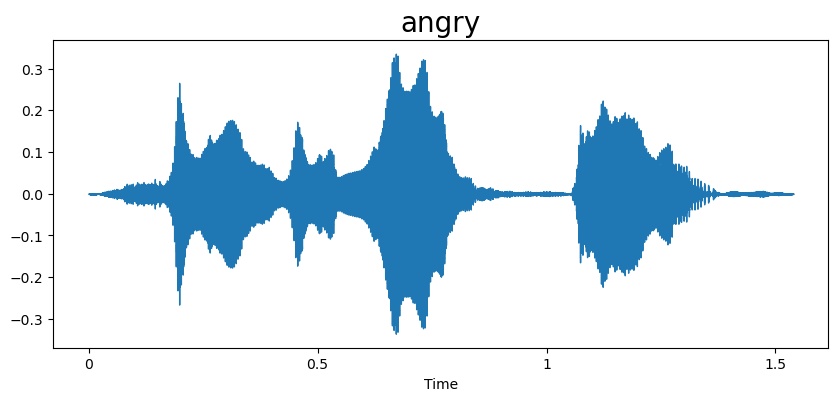

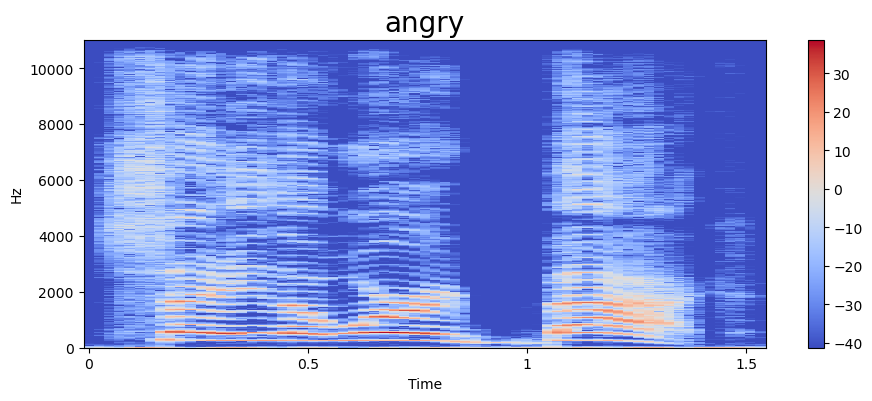

In [10]:
emotion = 'angry'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

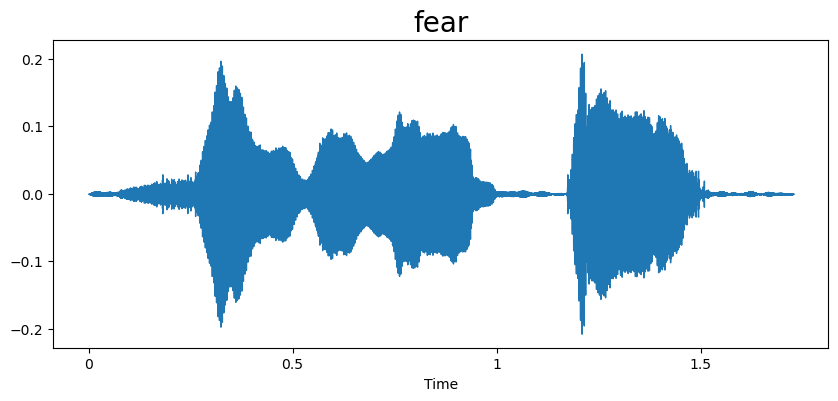

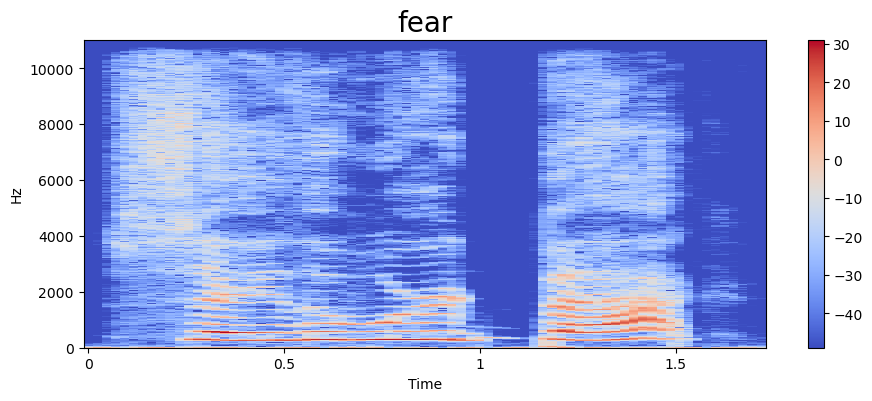

In [11]:
emotion = 'fear'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

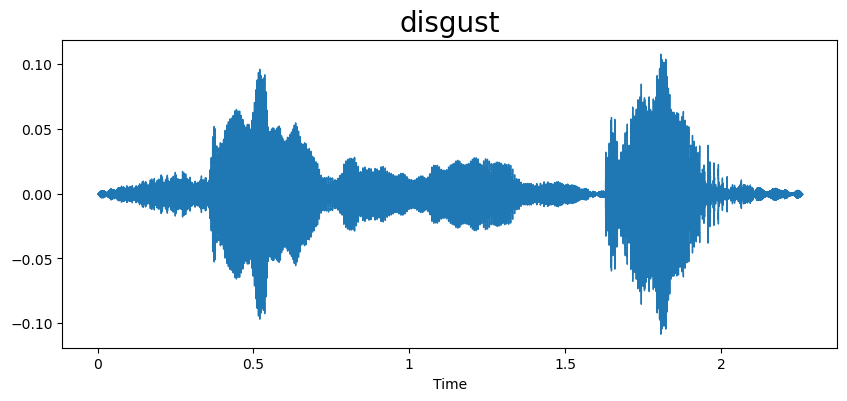

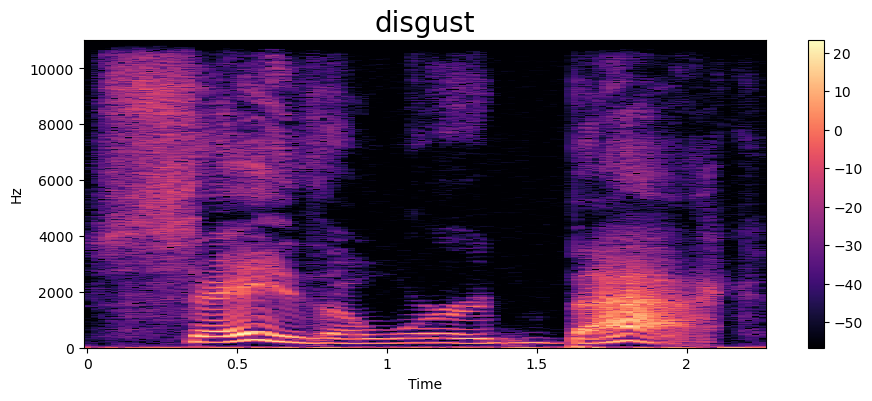

In [12]:
emotion = 'disgust'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

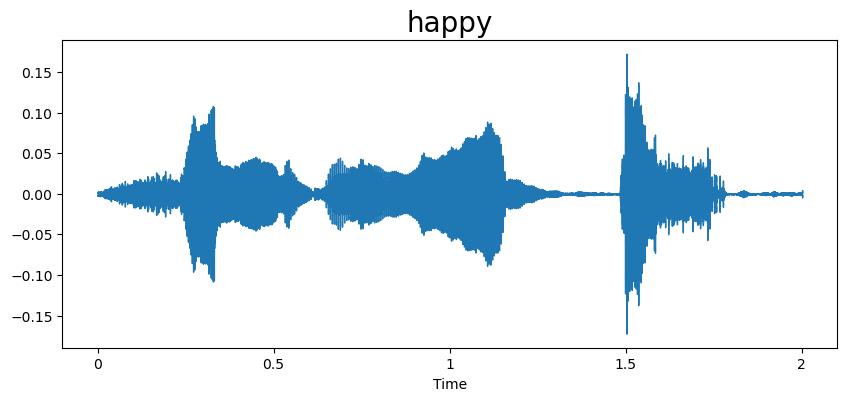

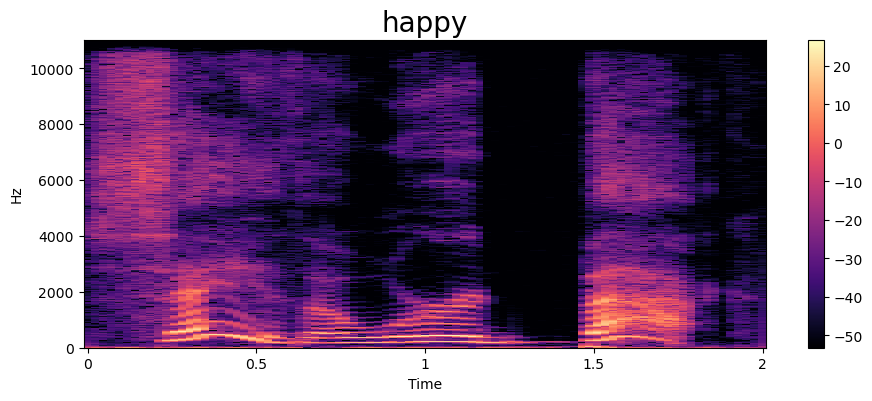

In [13]:
emotion = 'happy'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

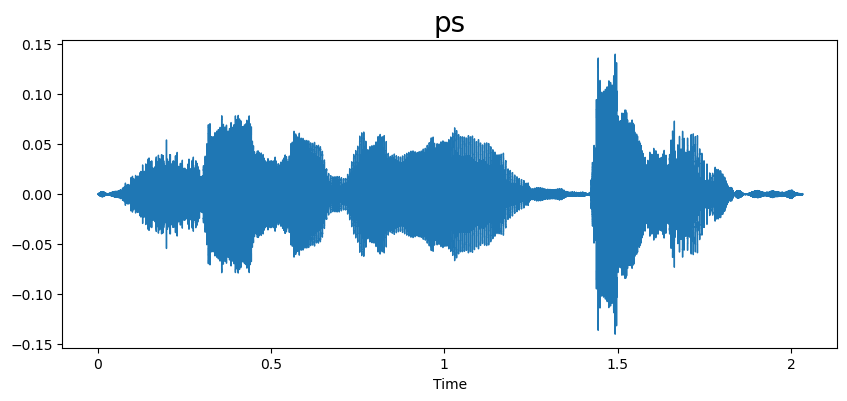

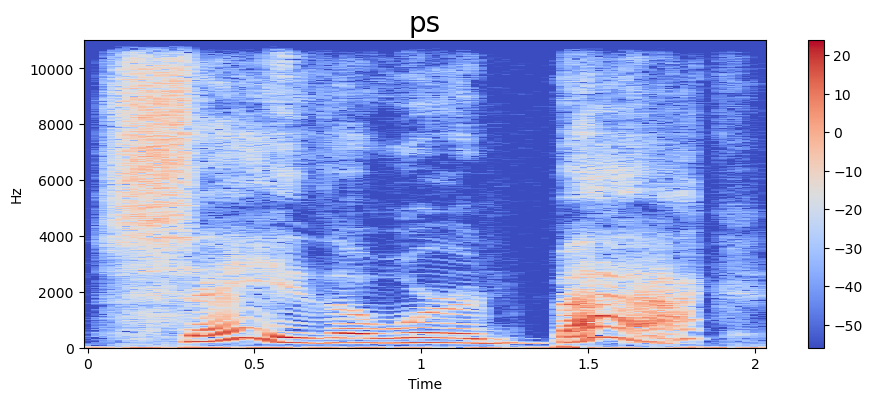

In [14]:
emotion = 'ps'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

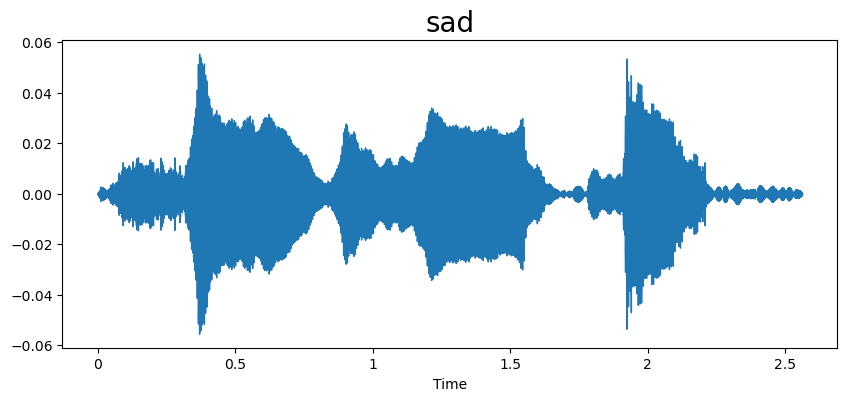

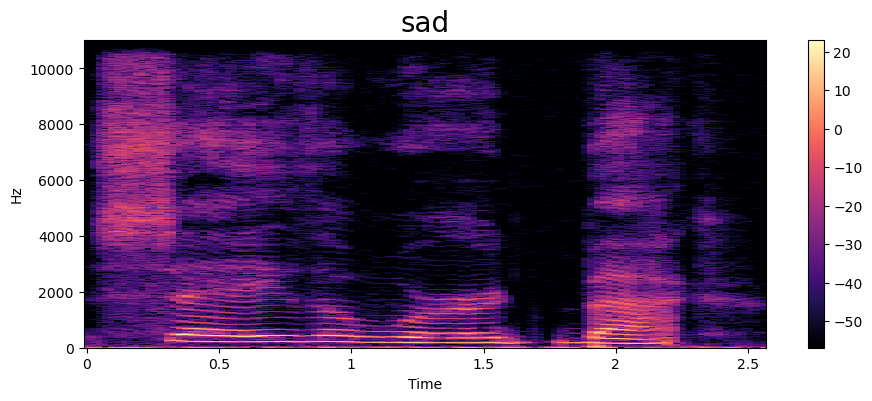

In [15]:
emotion = 'sad'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

# Create custom model -1

In [16]:
'''emotion = 'ps'
path = np.array(df['audio_paths'][df['labels']==2])[0]
data,sampling_rate = librosa.load(path)
len(data0)
sampling_rate * 2'''

"emotion = 'ps'\npath = np.array(df['audio_paths'][df['labels']==2])[0]\ndata,sampling_rate = librosa.load(path)\nlen(data0)\nsampling_rate * 2"

In [17]:
lable_map ={label: idx for idx, label in enumerate(df['labels'].unique())}

In [75]:
inverse_lable_map = {idx: label for label, idx in lable_map.items()}
df['labels'] = df['labels'].map(lable_map)
df.head(2)

audio_paths  labels
0  Data/TESS Toronto emotional speech set data\OA...     NaN
1  Data/TESS Toronto emotional speech set data\OA...     NaN

In [50]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length = 16000):
        self.df = df
        self.processor = processor
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['labels']
        
        # load the audio dataset
        speech,sr = librosa.load(audio_path, sr=16000)
        # pad or truncate the speech to the required length 
        if  len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)),'constant')
        #preprocess the audio file 
        inputs= self.processor(speech,sampling_rate=16000,return_tensors='pt',padding=True,truncate = True, max_length=self.max_length)
        input_values = inputs.input_values.squeeze()
        return{'input_values': input_values, 'labels':torch.tensor(label,dtype = torch.long)}
        

In [51]:
#split the data for train and test 
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.2,random_state=42)

In [52]:
#initialize the processor and model 

processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-960h')
model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels=7)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
#load the dataset
train_dataset = SpeechEmotionDataset(train_df,processor)
test_dataset = SpeechEmotionDataset(test_df,processor)

In [54]:
train_dataset[0]['input_values'].size()

torch.Size([16000])

In [55]:
#create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=8,shuffle=True)

# Set Training Argument

In [60]:
training_args = TrainingArguments(
    output_dir='/results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[]
)

In [63]:
#create function for computing metrics
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids #orignal labels
    preds = np.argmax(pred.predictions,axis=1)#model predicting labels
    accuracy = accuracy_score(labels,preds)
    precision,recall, f1, _ = precision_recall_fscore_support(labels,preds,average='weighted')
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall":recall,
        "f1":f1
    }

In [64]:
# initialize the trainer 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= train_dataset,
    eval_dataset = test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

TrainOutput(global_step=420, training_loss=0.0842638924008324, metrics={'train_runtime': 3053.7312, 'train_samples_per_second': 2.201, 'train_steps_per_second': 0.138, 'total_flos': 6.100924032e+16, 'train_loss': 0.0842638924008324, 'epoch': 3.0})

# Print Results

In [65]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.024661097675561905, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 46.5127, 'eval_samples_per_second': 12.04, 'eval_steps_per_second': 0.752, 'epoch': 3.0}


# Test Predictions

In [82]:
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
idx = random.randrange(0,len(test_dataset))
print("Orignal Label:",inverse_lable_map[int(test_dataset[idx]['labels'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to(device)
model.to(device)


with torch.no_grad():
    outputs = model(input_values)
logits = outputs.logits
predicted_class = logits.argmax(dim=-1).item()
print("Predicted Label:", inverse_lable_map[predicted_class])

Orignal Label: disgust
Predicted Label: disgust


In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_emotion_from_audio(path, model, processor, label_map):
    # Load audio file
    speech, sr = librosa.load(path, sr=16000)
    
    # Pad or truncate
    max_length = 16000
    if len(speech) > max_length:
        speech = speech[:max_length]
    else:
        speech = np.pad(speech, (0, max_length - len(speech)), 'constant')

    # Process input
    inputs = processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)
    input_values = inputs.input_values.to(device)

    # Predict
    with torch.no_grad():
        outputs = model(input_values)
    predicted_class = torch.argmax(outputs.logits, dim=-1).item()
    emotion = label_map[predicted_class]

    return emotion

In [87]:
import ipywidgets as widgets
import tempfile
from IPython.display import display

uploader = widgets.FileUpload(accept='.wav', multiple=False)
display(uploader)

def handle_upload(change):
    if uploader.value:
        # Get uploaded content
        for name, file_info in uploader.value.items():
            with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as temp:
                temp.write(file_info['content'])
                audio_path = temp.name
                display(Audio(audio_path))
                emotion = predict_emotion_from_audio(audio_path, model, processor, inverse_lable_map)
                print(f"Predicted Emotion: {emotion}")

uploader.observe(handle_upload, names='value')


FileUpload(value={}, accept='.wav', description='Upload')

Predicted Emotion: happy


In [93]:
import sounddevice as sd
import scipy.io.wavfile as wav

def record_audio(duration=5, filename='recorded.wav', fs=16000):
    print("Recording...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
    sd.wait()
    print("Done!")
    wav.write(filename, fs, (recording * 32767).astype(np.int16))
    return filename

# Record and predict
recorded_path = record_audio()
display(Audio(recorded_path))
emotion = predict_emotion_from_audio(recorded_path, model, processor, inverse_lable_map)
print(f"Predicted Emotion: {emotion}")

Recording...
Done!


Predicted Emotion: sad


In [94]:
emotion_to_genre = {
    'happy': 'pop',
    'sad': 'acoustic',
    'angry': 'metal',
    'fear': 'ambient',
    'disgust': 'dark ambient',
    'neutral': 'chill',
    'ps': 'classical'
}


In [96]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Initialize Spotify client
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id='aea604b6720343eda35bf8bf4a3eef49',
    client_secret='cf8888e59a7e45a7810a2df32b36938c'
))


In [97]:
def recommend_music(emotion, favorite_artist):
    genre = emotion_to_genre.get(emotion.lower(), 'pop')

    # Search for the artist
    results = sp.search(q=f'artist:{favorite_artist}', type='artist', limit=1)
    if not results['artists']['items']:
        return f"Couldn't find artist {favorite_artist}."

    artist_id = results['artists']['items'][0]['id']

    # Get artist's top tracks
    top_tracks = sp.artist_top_tracks(artist_id)
    recommendations = []

    for track in top_tracks['tracks']:
        if genre in track['name'].lower() or genre in track['album']['name'].lower():
            recommendations.append((track['name'], track['external_urls']['spotify']))

    # Fallback if no genre-match
    if not recommendations:
        for track in top_tracks['tracks'][:3]:
            recommendations.append((track['name'], track['external_urls']['spotify']))

    return recommendations


In [99]:
favorite_artist = input("Who's your favorite singer? ")
predicted_emotion = emotion  # This comes from your model

music_suggestions = recommend_music(predicted_emotion, favorite_artist)

print(f"\n🎧 Based on your mood ({predicted_emotion}) and love for {favorite_artist}, here are some tracks:")
for name, url in music_suggestions:
    print(f"{name}: {url}")


Who's your favorite singer? kishore

🎧 Based on your mood (sad) and love for kishore, here are some tracks:
Pal Pal Dil Ke Paas - From "Blackmail": https://open.spotify.com/track/6sF70gMVf9jg8QEogyVqBl
Kishore Kumar Speaks And O Mere Dil Ke Chain (Film - Mere Jeevan Saathi): https://open.spotify.com/track/6DWfITTnKLZVGD75Y0zeFh
Yeh Sham Mastani: https://open.spotify.com/track/6UeEm5XPsleVD85kNHCu1n
